In [1]:
!pip install praw pymongo pandas spark-nlp gensim scikit-learn

In [2]:
# --- Cell 2: Scrape Reddit Data and Store in MongoDB ---
import pymongo
import praw

# Connect to MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["reddit_db"]
collection = db["reddit_posts"]
collection.delete_many({})  # Clear old data

# Reddit API setup
reddit = praw.Reddit(
    client_id='ZLoE1ulq1T1yt-fErdYdJQ',
    client_secret='iBIgUy7Hiu8TfZ8n1JcpJggd3MT3yQ',
    user_agent='data_analysis_script'
)

# Fetch posts and insert into MongoDB
queries = ["health", "family", "food"]
for query in queries:
    for post in reddit.subreddit("all").search(query, limit=100):
        doc = {
            "title": post.title,
            "text": post.selftext,
            "subreddit": post.subreddit.display_name,
            "upvotes": post.score,
            "comments": post.num_comments,
            "created": post.created_utc,
            "category": query
        }
        collection.insert_one(doc)

print("✅ Reddit posts scraped and stored in MongoDB.")


✅ Reddit posts scraped and stored in MongoDB.


In [3]:
for doc in collection.find().limit(5):
    print(doc)


{'_id': ObjectId('67f66fc2534a926fbbcb7937'), 'title': 'Health professionals of Reddit, what are your best health tips?', 'text': '', 'subreddit': 'AskReddit', 'upvotes': 60, 'comments': 270, 'created': 1307526379.0, 'category': 'health'}
{'_id': ObjectId('67f66fc2534a926fbbcb7938'), 'title': 'People with health anxiety, read this!', 'text': "Health anxiety ruined a year of my life with a million doctor's visits and sleepless nights and I want to set the record straight for everyone still suffering. Don't fall into the spiral.  \n1. Healthy bodies have weird sensations  \n2. Healthy bodies have tinglings, numbness and even random pain  \n3. Healthy bodies have sudden headaches  \n4. Healthy bodies have all manner of random shit happen all the time.  \nAnxiety will produce a number of symptoms that will manifest in your mind if you focus on them enough. If you obsess about brain cancer all night, your anxiety will in time manifest all the symptoms you fear if you look hard enough. It is

In [4]:
# --- Cell 3: Load Data from MongoDB & Preprocess with Spark NLP ---
import sparknlp
from pyspark.sql import SparkSession
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql.functions import col
import pandas as pd

# Start Spark session with Spark NLP
spark = sparknlp.start()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")


# Load data from MongoDB into Pandas
raw_data = list(collection.find())
df = pd.DataFrame(raw_data)
df['text'] = df['title'] + " " + df['text']
df = df[df['text'].str.strip() != ""]

# Convert to Spark DataFrame
spark_df = spark.createDataFrame(df[['text']]).limit(50)

# Build Spark NLP pipeline
document_assembler = DocumentAssembler().setInputCol("text").setOutputCol("document")
tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")
normalizer = Normalizer().setInputCols(["token"]).setOutputCol("normalized")
stopwords_cleaner = StopWordsCleaner().setInputCols(["normalized"]).setOutputCol("cleanTokens").setCaseSensitive(False)
stemmer = Stemmer().setInputCols(["cleanTokens"]).setOutputCol("stemmed")
finisher = Finisher().setInputCols(["stemmed"]).setOutputCols(["cleaned"]).setOutputAsArray(True).setCleanAnnotations(True)

pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    normalizer,
    stopwords_cleaner,
    stemmer,
    finisher
])

# Run the pipeline
model = pipeline.fit(spark_df)
spark_df_cleaned = model.transform(spark_df)


# Convert to Pandas for traditional NLP analysis
from pyspark.sql.functions import concat_ws

# Join tokens into a single space-separated string
flat_df = spark_df_cleaned.withColumn("cleaned_text", concat_ws(" ", col("cleaned")))

# Convert to Pandas DataFrame
cleaned_pd = flat_df.select("cleaned_text").toPandas()

# Final cleaned corpus as a list of strings
corpus = cleaned_pd['cleaned_text'].tolist()


print("✅ Text preprocessing complete.")


✅ Text preprocessing complete.


In [5]:
# --- Cell 4: TF-IDF and Cosine Similarity ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
cos_sim_matrix = cosine_similarity(X)

print("\n📊 Cosine Similarity (first 5 docs):")
print(cos_sim_matrix[:5, :5])


📊 Cosine Similarity (first 5 docs):
[[1.         0.01832122 0.431068   0.01247869 0.03033182]
 [0.01832122 1.         0.00830504 0.11242082 0.03558969]
 [0.431068   0.00830504 1.         0.00565661 0.01374947]
 [0.01247869 0.11242082 0.00565661 1.         0.02798683]
 [0.03033182 0.03558969 0.01374947 0.02798683 1.        ]]



🧠 Top LDA Topics:
(0, '0.067*"health" + 0.034*"mental" + 0.014*"absolut" + 0.014*"hire" + 0.014*"trainer"')
(1, '0.068*"health" + 0.026*"trump" + 0.022*"illinoi" + 0.018*"million" + 0.018*"u"')
(2, '0.091*"health" + 0.020*"jr" + 0.015*"rfk" + 0.011*"u" + 0.010*"ceo"')
(3, '0.048*"health" + 0.015*"ceo" + 0.015*"unitedhealth" + 0.015*"advic" + 0.015*"attack"')
(4, '0.031*"health" + 0.021*"anxieti" + 0.021*"bodi" + 0.021*"healthi" + 0.016*"doctor"')


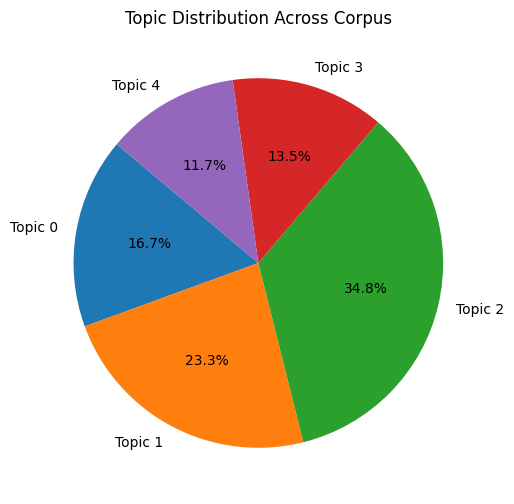

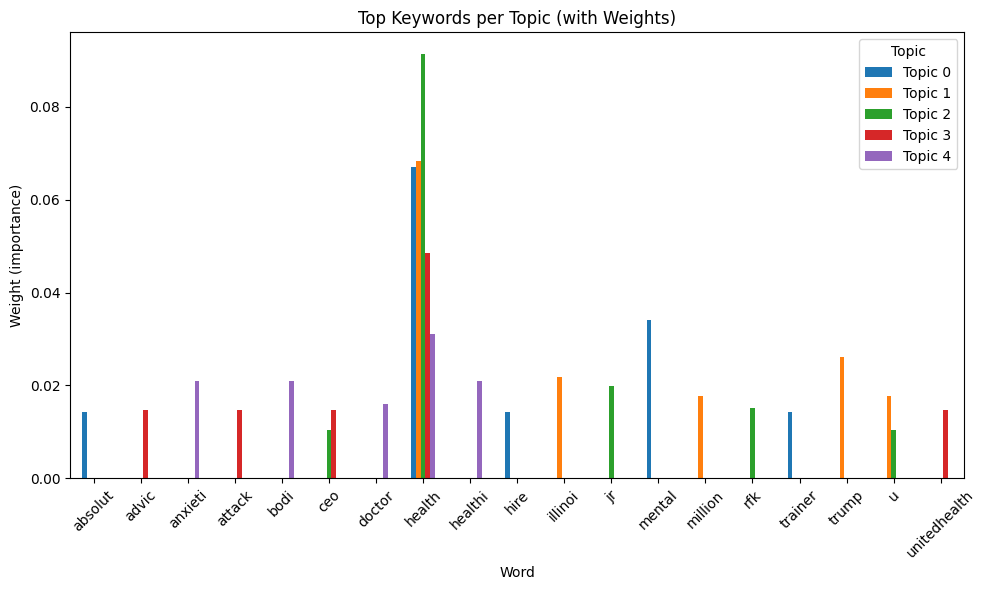

In [8]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from graphviz import Digraph
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Topic Modeling with Gensim LDA ---
texts = [doc.split() for doc in corpus]
dictionary = corpora.Dictionary(texts)
doc_term_matrix = [dictionary.doc2bow(text) for text in texts]

lda_model = LdaModel(corpus=doc_term_matrix,
                     id2word=dictionary,
                     num_topics=5,
                     random_state=42,
                     passes=10)

print("\n🧠 Top LDA Topics:")
for topic in lda_model.print_topics(num_words=5):
    print(topic)

# --- Flowchart Visualization ---
dot = Digraph(comment='LDA Topic Modeling Flow', format='png')

dot.node('A', 'Raw Corpus')
dot.node('B', 'Tokenize & Preprocess')
dot.node('C', 'Create Dictionary')
dot.node('D', 'Document-Term Matrix')
dot.node('E', 'Train LDA Model')
dot.node('F', 'Display Topics')

dot.edges(['AB', 'BC', 'CD', 'DE', 'EF'])

# Save and optionally open
dot.render('lda_workflow', view=True)


# --- Pie Chart: Topic Distribution ---
topic_counts = [0] * lda_model.num_topics
for doc in doc_term_matrix:
    topics = lda_model.get_document_topics(doc)
    for topic_id, prob in topics:
        topic_counts[topic_id] += prob

# Normalize and plot
topic_sums = np.array(topic_counts) / sum(topic_counts)
labels = [f"Topic {i}" for i in range(len(topic_sums))]

plt.figure(figsize=(6, 6))
plt.pie(topic_sums, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Topic Distribution Across Corpus")
plt.show()


# --- Bar Graph: Top Words per Topic (with Weights) ---
top_words_data = []
for t in range(lda_model.num_topics):
    top_words = lda_model.show_topic(t, topn=5)
    for word, weight in top_words:
        top_words_data.append({'Topic': f'Topic {t}', 'Word': word, 'Weight': weight})

# Convert to DataFrame
df_top_words = pd.DataFrame(top_words_data)

# Pivot for plotting
pivot_df = df_top_words.pivot(index='Word', columns='Topic', values='Weight')

# Plot
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title("Top Keywords per Topic (with Weights)")
plt.ylabel("Weight (importance)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
